In [6]:
import random
from pathlib import Path

from tqdm import tqdm
from PIL import Image
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
import albumentations.augmentations.transforms as aug

from src.lanutils.plot import get_colors

%matplotlib inline

## Check the shape of the image 

(256, 1600, 3)
18 241


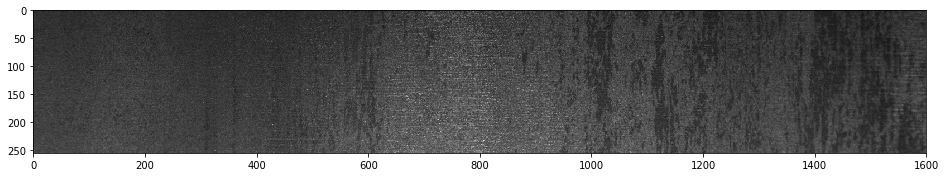

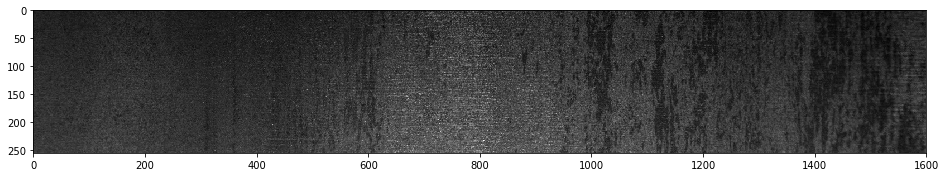

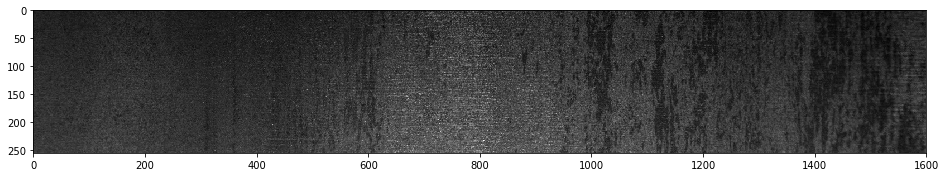

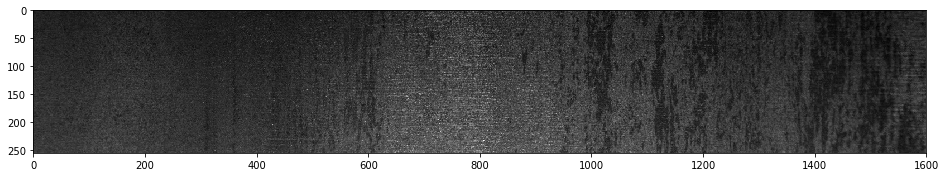

In [7]:
im = cv2.imread('/data2/datasets/kaggle/severstal-steel-defect-detection/raw/trainval/00ded7837.jpg')
print(im.shape)
print(im.min(), im.max())
plt.figure(figsize=(16, 10)); plt.imshow(im)
plt.figure(figsize=(16, 10)); plt.imshow(im[..., 0], cmap='gray')
plt.figure(figsize=(16, 10)); plt.imshow(im[..., 1], cmap='gray')
plt.figure(figsize=(16, 10)); plt.imshow(im[..., 2], cmap='gray')

## Get Image Paths
Including both **trainval** and **test**

In [8]:
dataset_dir = Path('/data2/datasets/kaggle/severstal-steel-defect-detection/raw')
im_paths = sorted(dataset_dir.rglob("*.jpg"))
print(f"{len(im_paths)} images found in total.")
print(f"{[str(p) for p in im_paths[:5]]}")

14369 images found in total.
['/data2/datasets/kaggle/severstal-steel-defect-detection/raw/test/004f40c73.jpg', '/data2/datasets/kaggle/severstal-steel-defect-detection/raw/test/006f39c41.jpg', '/data2/datasets/kaggle/severstal-steel-defect-detection/raw/test/00b7fb703.jpg', '/data2/datasets/kaggle/severstal-steel-defect-detection/raw/test/00bbcd9af.jpg', '/data2/datasets/kaggle/severstal-steel-defect-detection/raw/test/0108ce457.jpg']


## Check whether all 3 channels are identical

In [ ]:
def identical(a, b):
    return (a == b).sum() == a.size == b.size

channel_identical_cnt = 0
for p in tqdm(im_paths):
    im = cv2.imread(str(p))
    if identical(im[..., 0], im[..., 1]) and identical(im[..., 2], im[..., 1]):
        channel_identical_cnt += 1

print(f"{channel_identical_cnt}/{len(im_paths)} are identical.")

## Check How black is the margin

There're black margins in some of the images. We wanted to see how does those margins look like, so we can add similar margins in our online augmentation.

thresh == 30

In [ ]:
def contain_black_margin(im, thresh=30):
    im_grayscale = im[..., 0]
    im_grayscale[im_grayscale < thresh] = 0
    squashed_into_a_row = im_grayscale.sum(axis=0)
    row_nonzero = squashed_into_a_row.nonzero()[0]
    left, right = 0, im_grayscale.shape[1] - 1
    if len(row_nonzero) > 0:
        left, right = row_nonzero[0], row_nonzero[-1]
    if left > 0 or right < im_grayscale.shape[1] - 1:
        return True
    return False


im_paths_with_black_margin = [p for p in tqdm(im_paths) if contain_black_margin(cv2.imread(str(p)))]
print(f"Found {len(im_paths_with_black_margin)} images with black margin.")
for p in im_paths_with_black_margin[:5]:
    plt.figure(figsize=(16, 10)); plt.imshow(cv2.imread(str(p)))

## Check How Many Images Contain Both Black Margins


In [ ]:
def contain_both_black_margin(im, thresh=30):
    im_grayscale = im[..., 0]
    im_grayscale[im_grayscale < thresh] = 0
    squashed_into_a_row = im_grayscale.sum(axis=0)
    row_nonzero = squashed_into_a_row.nonzero()[0]
    left, right = 0, im_grayscale.shape[1] - 1
    if len(row_nonzero) > 0:
        left, right = row_nonzero[0], row_nonzero[-1]
    if left > 0 and right < im_grayscale.shape[1] - 1:
        return True
    return False


im_paths_with_both_black_margins = [p for p in im_paths if contain_both_black_margin(cv2.imread(str(p)))]
print(f"Found {len(im_paths_with_both_black_margins)} images with black margin.")
for p in im_paths_with_both_black_margins[:5]:
    plt.figure(figsize=(16, 10)); plt.imshow(cv2.imread(str(p)))

## Try different transformation on the images / masks
* Rotate
* GridDistortion
* HorizontalShiftAndPad

### Get paths of images with defects

In [24]:
def get_indices_with_defects(label_path):
    with open(label_path, 'r') as f:
        return list({l.split('.')[0] for l in f if len(l.split(' ')) > 1})
    
image_dir = Path('/data2/datasets/kaggle/severstal-steel-defect-detection/raw/trainval')
mask_dir = Path('/data2/datasets/kaggle/severstal-steel-defect-detection/label/trainval')
indices = get_indices_with_defects('/data2/datasets/kaggle/severstal-steel-defect-detection/label/train.csv')
print(f"{len(indices)} images found with defect.")
print(f"{indices[:5]}") 

6666 images found with defect.
['bdee0e677', 'c795455ba', '354760e3e', '948f9558f', 'e4547788b']


### Rotation (PyTorch)

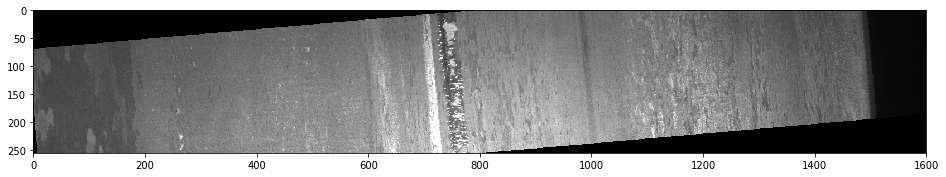

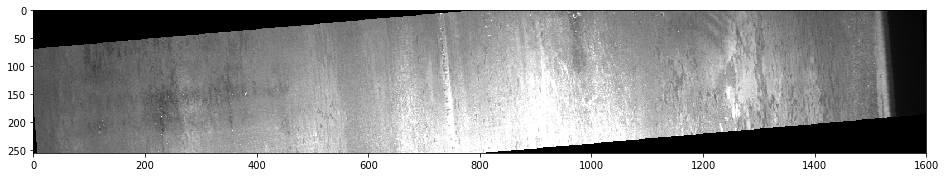

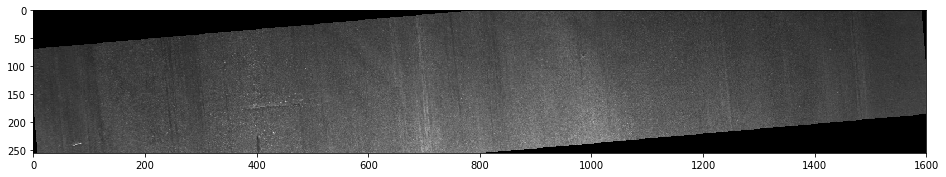

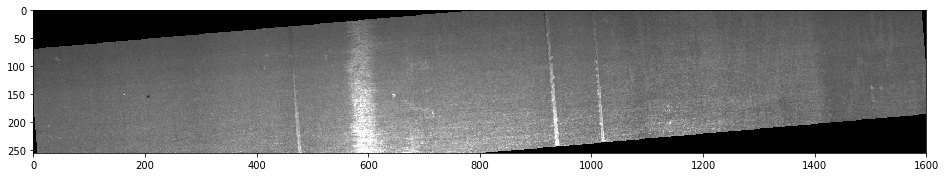

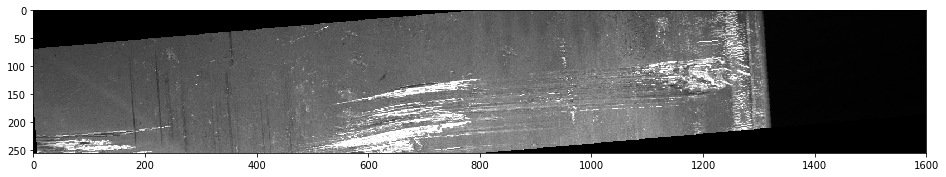

In [25]:
def plot(_im, figsize=(16, 10)):
    plt.figure(figsize=figsize); plt.imshow(_im)

for p in indices[:5]:
    img = Image.open(image_dir / f"{p}.jpg")
    rotated_img = TF.rotate(img, 5)
    plot(np.array(rotated_img))


### Rotation (Albumentations)
##### border_mode=cv2.BORDER_REFLECT_101

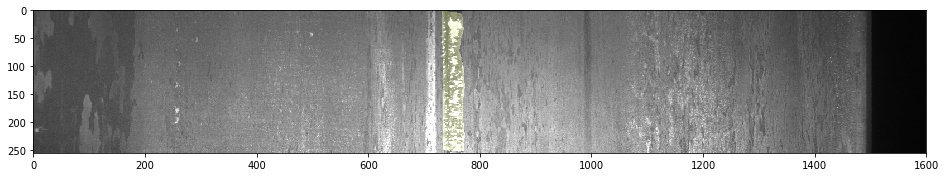

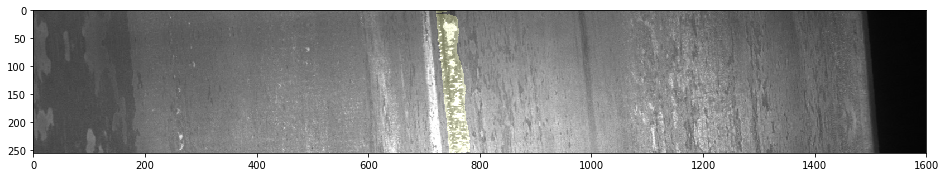

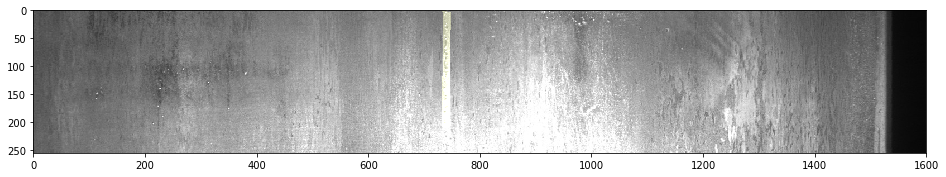

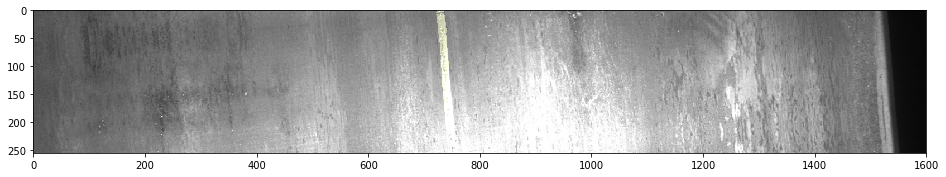

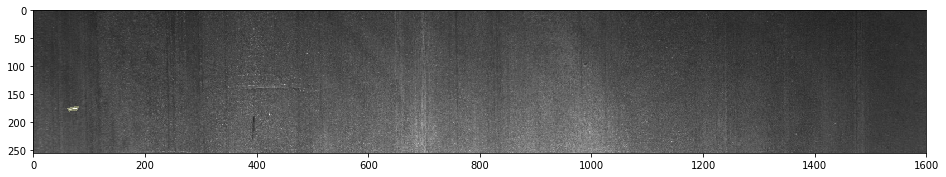

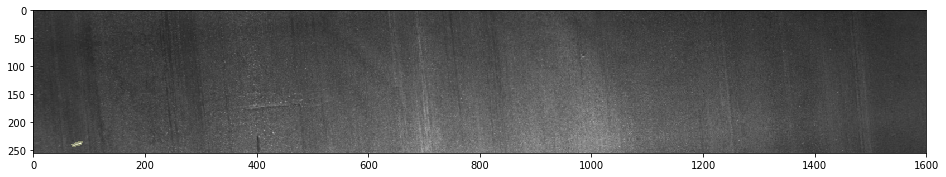

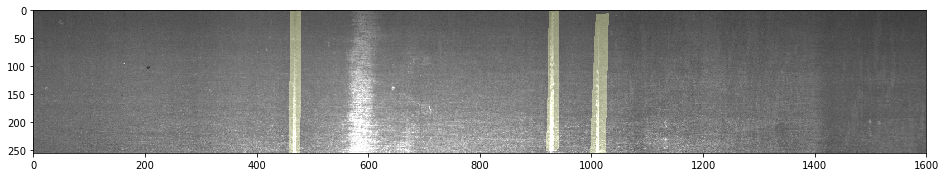

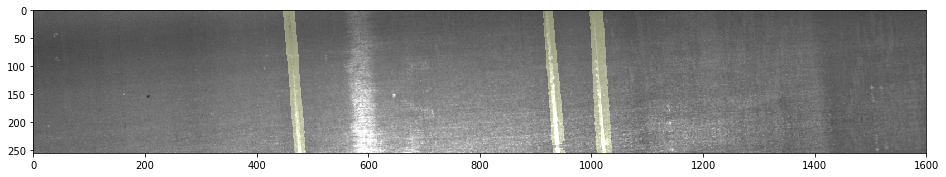

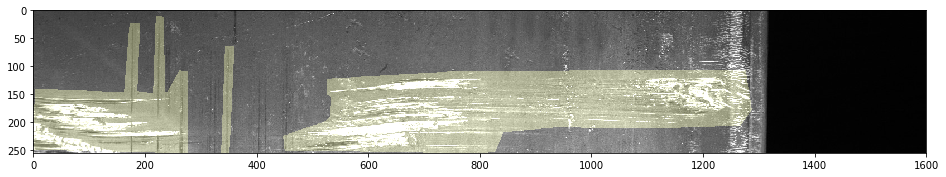

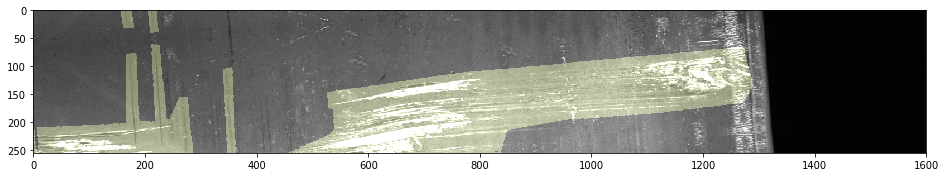

In [26]:
colors = get_colors(4)
def overlay_seglabel(_img, _msk):
    for m in range(_msk.shape[-1]):
        colored_msk = (_msk[..., m:m+1].repeat(3, axis=2) * colors[m]).astype(np.uint8)
        _img = cv2.addWeighted(_img, 1.0, colored_msk, 0.3, 0)
    return _img

rotate = aug.Rotate(
    limit=(5, 5), 
    interpolation=cv2.INTER_AREA, 
    border_mode=cv2.BORDER_REFLECT_101,
    always_apply=True,
)
for p in indices[:5]:
    img = cv2.imread(str(image_dir / f"{p}.jpg"))
    msk = np.load(str(mask_dir / f"{p}.npz"))['mask'].transpose(1, 2, 0)
    merged = overlay_seglabel(img, msk)
    plot(merged)
    
    rotated_img = rotate(image=img)['image']
    rotated_msk = rotate(image=msk)['image']
    rotated_merged = overlay_seglabel(rotated_img, rotated_msk)
    plot(rotated_merged)
    

### Rotation (Albumentations)
##### border_mode=cv2.BORDER_REPLICATE

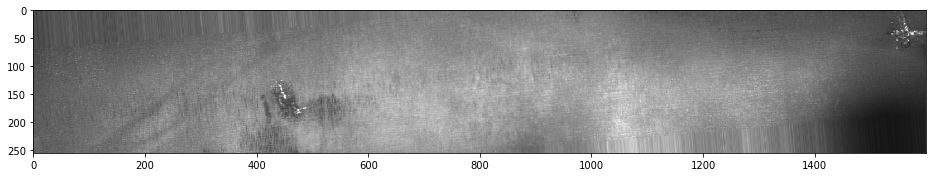

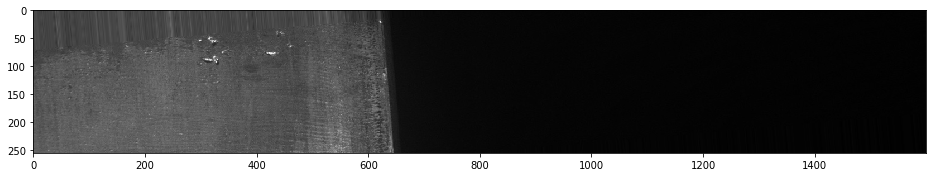

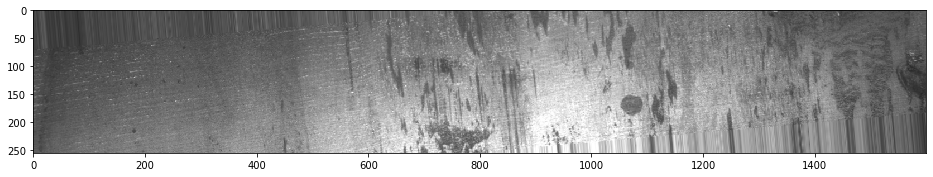

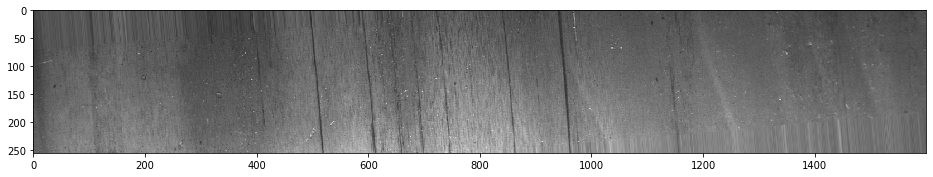

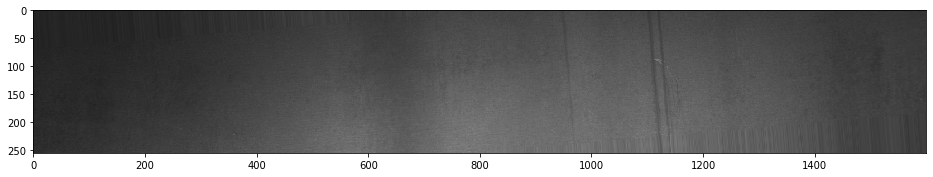

In [59]:
rotate = aug.Rotate(
    limit=(5, 5), 
    interpolation=cv2.INTER_AREA, 
    border_mode=cv2.BORDER_REPLICATE,
    always_apply=True,
)
for p in indices[:5]:
    img = cv2.imread(str(image_dir / f"{p}.jpg"))
    rotated_img = rotate(image=img)['image']
    plot(np.array(rotated_img))
    

### GridDistortion (Albumentations)
**IMPORTANT**: When doing GridDistortion for both image and seglabel (mask), we must make sure they are using the same distortion params, because the params are randomly draw from 2 uniform distribution.

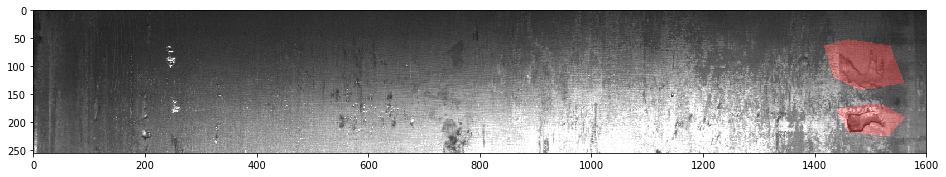

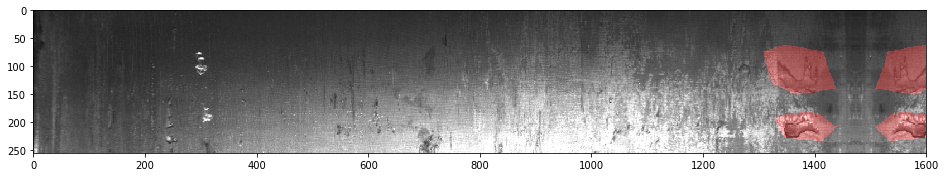

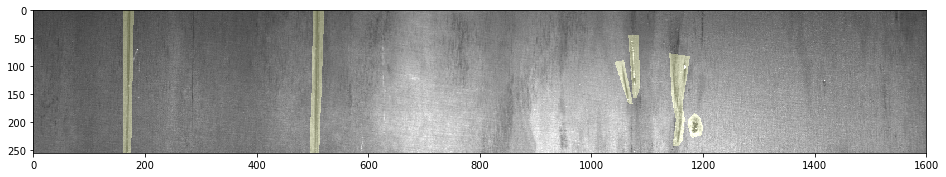

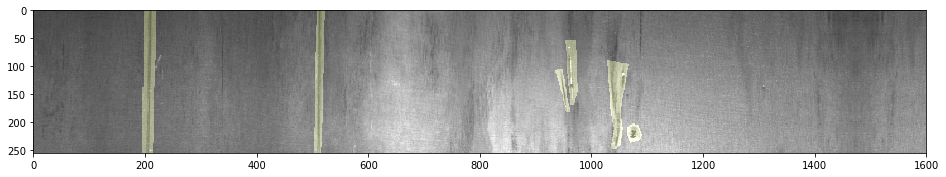

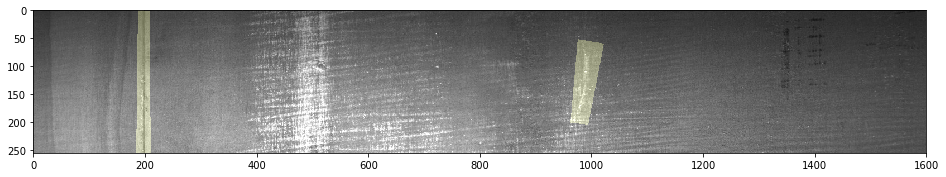

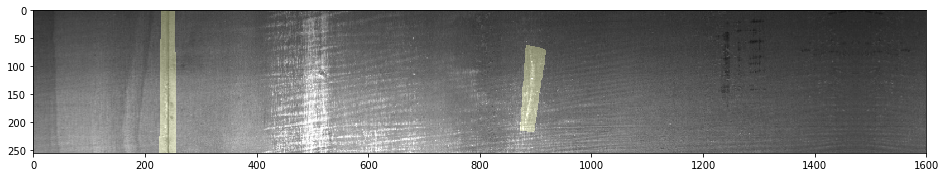

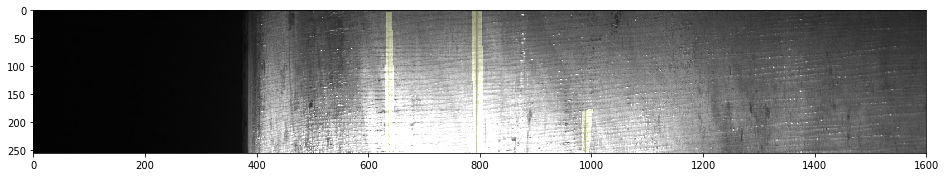

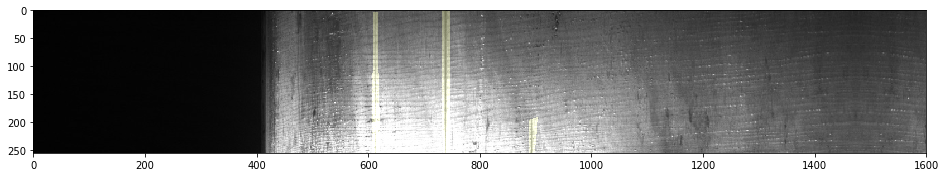

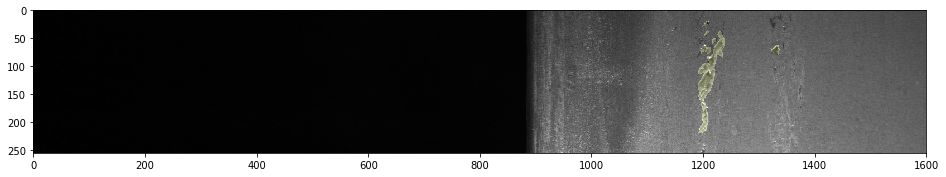

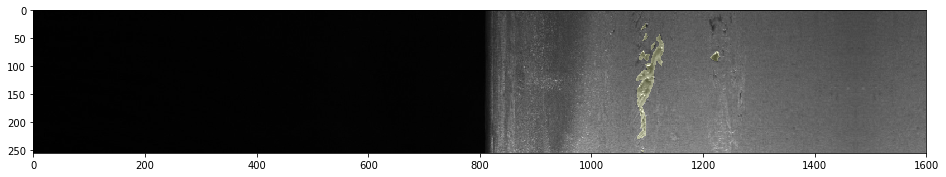

In [32]:
grid_distortion = aug.GridDistortion(
    num_steps=5, 
    distort_limit=0.3,
    interpolation=cv2.INTER_AREA, 
    always_apply=True,
)

for _ in range(5):
    idx = np.random.randint(len(indices))
    img = cv2.imread(str(image_dir / f"{indices[idx]}.jpg"))
    msk = np.load(str(mask_dir / f"{indices[idx]}.npz"))['mask'].transpose(1, 2, 0)
    merged = overlay_seglabel(img, msk)
    plot(merged)
    
    random.seed(101)
    distort_img = grid_distortion(image=img)['image']
    random.seed(101)
    distort_msk = grid_distortion(image=msk, mask=msk)['mask']
    distort_merged = overlay_seglabel(distort_img, distort_msk)
    plot(distort_merged)


### HorizontalShiftAndPad
